# [Ubiquant] Simple LGBM removing Outliers

This competition is provided by a investment company in Beijing, China. The task is to predict future indicators for aprx.3000 investment items based on 300 market trading indicators.  
This is the simple LGBM, and I tried to see how Public Score is improved by removing outliers.     

今回は中国・北京の投資会社からのお題。300のマーケット情報（匿名化されているので何の指標なのかは不明）をもとに、3000近くの投資銘柄の将来指標を予測するコンペ。シンプルなLGBMで、主として外れ値（Outlier）除外することでどの程度スコアが改善するか試してみました。  

**< Score Improvement History >**  
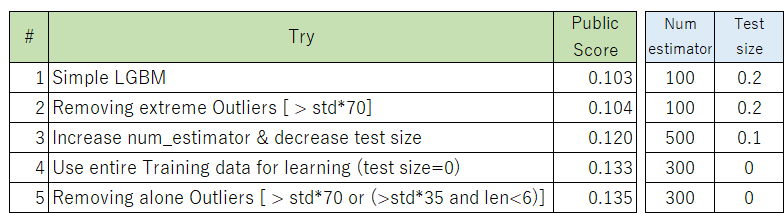

# (1) Read Trainiing Data

Training data for this competition is very huge 18.6GB, and hence it will cause Memory-over if use for training.  
Thanks to https://www.kaggle.com/c/ubiquant-market-prediction/discussion/301724 for sharing low-memory training data.  

今回のトレーニングデータは18.6GBと巨大なので、そのまま学習に使うとメモリーオーバーになる。  
上記のリンク先Discussionで、メモリーサイズを抑えたトレーニングデータが公開されているので、有り難く使わせていただく。

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgbm
from lightgbm import *
pd.set_option("display.max_columns", None)

In [ ]:
df_train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
df_train

# (2) Overview of training data and outliers

Let's take a quick look at the 15 columns out of total 300 Market indicators used for prediction.

予測に使う300のマーケット指標のうち、とりあえず最初の15項目を見てみる。

In [ ]:
plt.figure(figsize=(20,20))
for i in range(15) :
    plt.subplot(5, 5, i+1)
    plt.hist(df_train[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show

It seems f_1 or f_5 is almost near to normal distribution and easy for machine to learn, while f_3 or F_4 looks warped figure and likely hard to learn. I think this warped figure is due to outliers and would like to look into them more in detail.  
In case of f_1 which looks normal distribution, Max/Min is within std x 10. On the contrary, in case of f_3, 4, 8, 10, 11, 13 which are far from normal distribution, there are outliers which are over dozens times of std. 


f_1やf_5などは正規分布に近いのですごく学習しやすそうだけれど、f_3やf_4などはかなりいびつな分布であり、学習しにくそう。おそらく極端な外れ値のせいでこのような分布になっているのではないかと思うので、いびつな形をした分布を少し詳しく見てみる。  
正規分布に見えるf_1は、Max/Minともに標準偏差の10倍以内に収まっているが、正規分布とは程遠いf_3, 4, 8, 10, 11, 13を見てみると、標準偏差の数十倍を超えている外れ値が見られる。

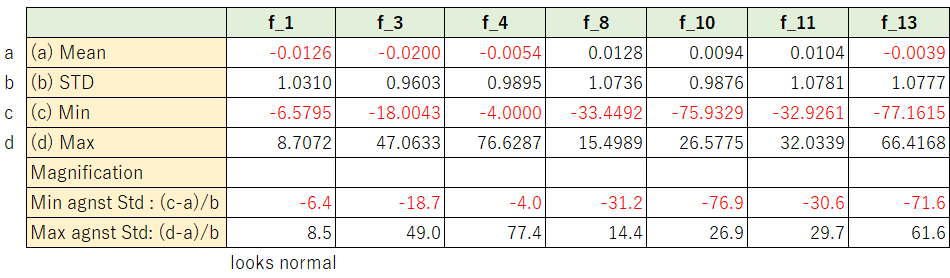

In [ ]:
df_train.describe()

In [ ]:
feature_cols = df_train.columns.unique()
feature_cols = feature_cols.drop(["row_id", "time_id", "target"])
feature_cols

# (3) Removing extreme Outliers (> std*70)

Try to remove the records with extreme outliers which are over std x 70 from the mean, since it is not good to remove too many records. There are 128 records included in 17 indicators(columns).  
When remove these 128 outlier records, Public score was slightly improved by **+0.001** from 0.103 to 0.104. (in case of base score 0.132, improved to 0.133.)

外れ値も除外しすぎると良くないので、とりあえず平均値から標準偏差の70倍を超える極端な外れ値をもつレコードをトレーニングデータから除外する。  
全部で17指標、128レコードある。  
これら128レコードを除去してシンプルLGBMを回すと、スコアは0.103→0.104へと、**+0.001**だけ僅かに改善（ベーススコアが0.132の場合0.133に。）

In [ ]:
outlier_list = []

for col in feature_cols :
    
    temp_df = df_train[(df_train[col] > df_train[col].mean() + df_train[col].std() * 70) |
                       (df_train[col] < df_train[col].mean() - df_train[col].std() * 70) ]
    if len(temp_df) >0 :
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        print(col, len(temp_df))

outlier_list = list(set(outlier_list))
print(len(outlier_list))

# (4) Remove alone Outliers [> std x70 or (>std x35 and len<6)]

In the above(3), I tried to remove only extreme outliers (>std x70), but I guess if try to remove less extreme outliers which exist all alone then the distribution would become near to normal and easier for machine to learn. (please refer to the below example f_214)   
Therefore, I tried to remove more outliers (>std x35 and the number is less than 6).   
Target records for removal was increased to 48 indicators, 174 records.  
The result is, Public score was improved by **+0.002** from 0.133 to 0.135.

上記(3)では、標準偏差の70倍以上という極端な外れ値のみ除外したが、ここまで極端ではないにしても１つないし数個だけポツンと存在している外れ値を除外すれば、正規分布に近づき学習が改善するColumnも多いはず。（f_214の例をご参照）  
ということで、上記(3)に加え、標準偏差は半分（35倍以上）で数は5個以下という外れ値を除外してみる。除外対象は48指標、174レコードに増加。  
結果は、Public Scoreが0.133から0.135へと、**+0.002**改善した。

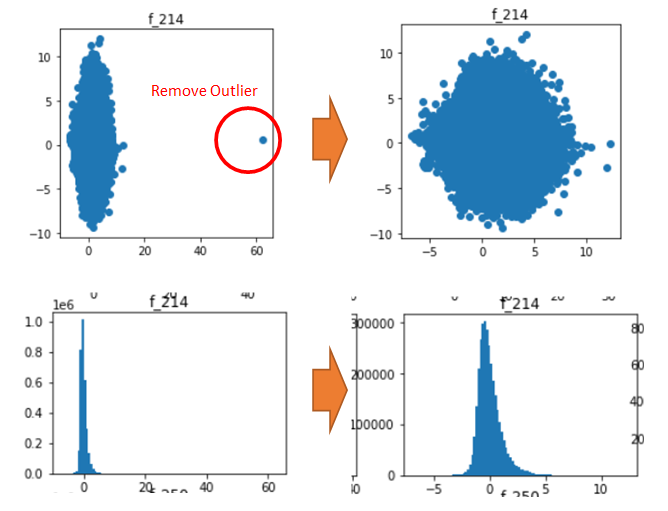

In [ ]:
outlier_list = []
outlier_col = []

for col in feature_cols :
    
    temp_df = df_train[(df_train[col] > df_train[col].mean() + df_train[col].std() * 70) |
                       (df_train[col] < df_train[col].mean() - df_train[col].std() * 70) ]
    temp2_df = df_train[(df_train[col] > df_train[col].mean() + df_train[col].std() * 35) |
                        (df_train[col] < df_train[col].mean() - df_train[col].std() * 35) ]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
print(len(outlier_col), len(outlier_list))

Let me show the scatter plot of f_165, f_214, f_295 as typical columns whiose scatter is changed before/after removing outliers.  
Only 1 record much warps the scattering. (Just FYI, this 1 record is "2477085".) 

外れ値除去の前後でデータの散らばり具合が変わる典型的なColumnがf_165, f_214, f_295なので、この３つの散布図を出しておきます。  
たった1レコードのせいで、散布度合いはこんなに歪んでいるんだ。（ちなみに、この１レコードは「2477085」です。

In [ ]:
plt.figure(figsize=(20,20))
for i, (col) in enumerate(["f_165", "f_214", "f_295"]) :
    plt.subplot(5, 5, i+1)
    plt.scatter(df_train[col], df_train["target"])
    plt.title(col)
plt.show

# Remove outliers  外れ値の除去


In [ ]:
df_train.drop(df_train.index[outlier_list], inplace = True)
df_train

Below is the scatter plot of f_165, f_214, f_295 after removing outliers.  
Well, only 1 record removal contribute to this much improvement of scatter.

以下が、外れ値を除去した後のf_165, f_214, f_295の散布図。  
たった1レコードを除去するだけで、こんなに散布度合いが改善するんだ。

In [ ]:
plt.figure(figsize=(20,20))
for i, (col) in enumerate(["f_165", "f_214", "f_295"]) :
    plt.subplot(5, 5, i+1)
    plt.scatter(df_train[col], df_train["target"])
    plt.title(col)
plt.show

In [ ]:
plt.figure(figsize=(20,20))
for i in range(15) :
    plt.subplot(5, 5, i+1)
    plt.hist(df_train[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show

# (5) Further memory reduce 

Further try to make the data lighter to avoid Memory-over error.  
Not sure who created, but the below function has been widely used for this purpose. Many thanks to the original creator (^v^)/

メモリーオーバーエラー防止のため、さらにデータを軽くする。  
どなたが作ってくれたのか分かりませんが、この目的では広く以下の関数が使われています。作成者に感謝です　(^v^)/

In [ ]:
def reduce_mem_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

# (6) Build model  

Followings are my improvement history...  
①　Simple LGBM with num_estimators=100, test size=20% 　⇒　Public Score : **0.103**  
②　Change num_estimators=500, test_size=10%　　　　　　⇒　Public Score : **0.120**  
　　　(early stopping around 240)  
③　Use whole Training data (test size 0)  　　　　　　　　　 ⇒　Public Score : **0.133**

以下はスコア改善履歴です。  
①　学習回数100回、テストサイズ20%（訓練データ80%）のシンプルなLGBM　⇒　Public Score : **0.103**  
②　学習回数500回、テストサイズ10%（訓練データ90%）に変更 　　　　　　⇒　Public Score : **0.120**  
　　　(early stopping around 240)  
③　訓練データ全体を学習に使用（テストサイズ 0）　　　　　　　　　　　　⇒　Public Score : **0.133**

In [ ]:
y = df_train['target'].copy()
x = df_train[feature_cols]

#x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, shuffle=False)

In [ ]:
model_entire = lgbm.LGBMRegressor(
        objective="regression",
        metric="rmse",
        n_estimators=300 )

In [ ]:
%%time

model_entire.fit(x,y)

"""
model.fit(x_train, y_train,
          eval_set=[(x_valid, y_valid)],
          eval_metric='rmse',
          callbacks=[early_stopping(20), log_evaluation(20)])
"""

# (7) Prediction and Submission

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    
    test_df = test_df[feature_cols]
    y_pred  = model_entire.predict(test_df)
    sample_prediction_df["target"] = y_pred
    
    display(test_df)
    display(sample_prediction_df)
    
    env.predict(sample_prediction_df)